In [1]:
#  Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)

In [6]:
# Replace 'your_file.csv' with your actual file path
df = pd.read_csv(r'C:\Users\marco\OneDrive\Desktop\Tesi_Codice\Cognitive_TaskGen\backbone creation\raid_sample_small_with_features_CLEANED.csv')

# Display basic info
print(f"Dataset shape: {df.shape}")
print(f"\nLength bins available: {sorted(df['length_bin'].unique())}")
print(f"\nModels available: {df['model'].unique()}")
print(f"\nAI texts: {df['is_ai'].sum()}, Human texts: {(~df['is_ai']).sum()}")

Dataset shape: (3000, 62)

Length bins available: ['long', 'medium', 'short']

Models available: ['chatgpt' 'gpt3' 'human' 'mpt' 'gpt2' 'mistral' 'cohere' 'llama-chat'
 'cohere-chat' 'mpt-chat' 'gpt4' 'mistral-chat']

AI texts: 1500, Human texts: 1500


In [7]:
feature_categories = {
    'Statistical': ['alpha_ratio', 'digit_ratio', 'punct_ratio', 'std_word_length', 
                   'entropy_bits', 'entropy_norm'],
    'Token-based': ['n_tokens_doc', 'trigram_diversity', 'token_burstiness', 'stopword_ratio'],
    'Sentence-based': ['avg_sentence_length', 'sentence_length_std', 'n_sentences_doc'],
    'Character-based': ['char_trigram_entropy', 'uppercase_ratio', 'whitespace_ratio', 
                       'unique_char_count'],
    'Syntactic': ['avg_tree_depth', 'max_tree_depth', 'avg_dependency_distance', 'yules_k'],
    'Punctuation': ['comma_ratio', 'period_ratio', 'question_ratio', 'exclamation_ratio', 
                   'semicolon_ratio', 'colon_ratio', 'quote_ratio', 'punctuation_ratio'],
    'Sentiment': ['sentiment_polarity', 'sentiment_subjectivity', 'sentiment_polarity_variance', 
                 'neutral_sentence_ratio', 'positive_word_ratio', 'negative_word_ratio'],
    'Quality': ['quality_score', 'readability_anomaly', 'lexical_anomaly']
}

# Flatten all features into a single list
all_features = [feat for category in feature_categories.values() for feat in category]
print(f"Total features to analyze: {len(all_features)}")

Total features to analyze: 38


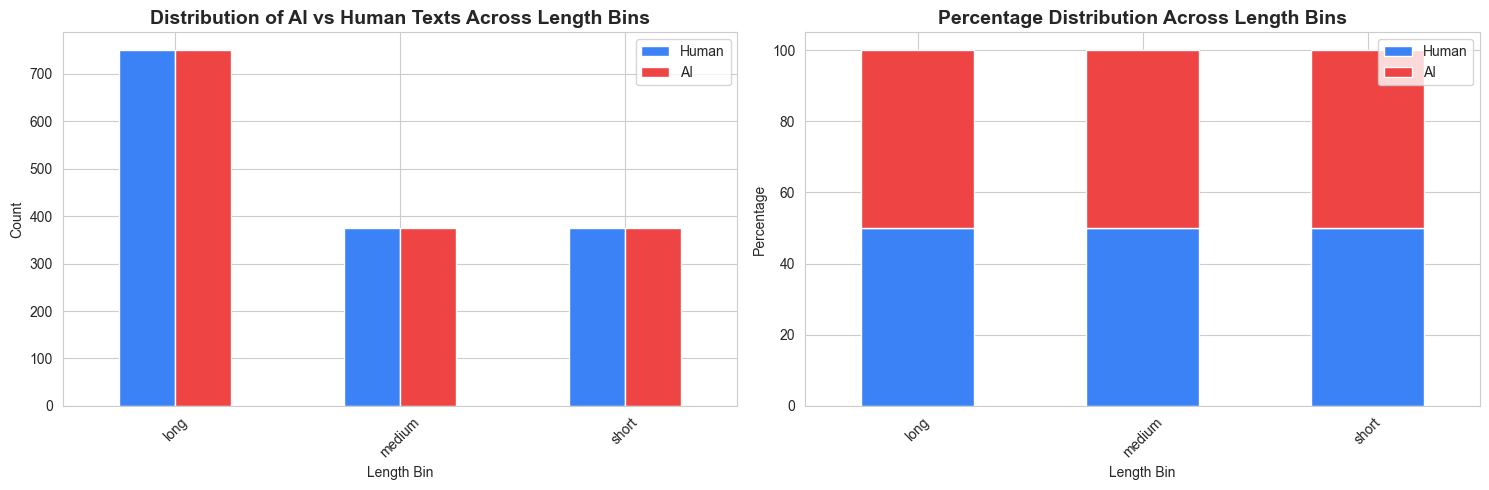

In [ ]:
#Sanity Check

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Count plot
count_data = df.groupby(['length_bin', 'is_ai']).size().unstack(fill_value=0)
count_data.plot(kind='bar', ax=axes[0], color=['#3b82f6', '#ef4444'])
axes[0].set_title('Distribution of AI vs Human Texts Across Length Bins', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Length Bin')
axes[0].set_ylabel('Count')
axes[0].legend(['Human', 'AI'])
axes[0].tick_params(axis='x', rotation=45)

# Percentage plot
pct_data = df.groupby(['length_bin', 'is_ai']).size().unstack(fill_value=0)
pct_data = pct_data.div(pct_data.sum(axis=1), axis=0) * 100
pct_data.plot(kind='bar', stacked=True, ax=axes[1], color=['#3b82f6', '#ef4444'])
axes[1].set_title('Percentage Distribution Across Length Bins', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Length Bin')
axes[1].set_ylabel('Percentage')
axes[1].legend(['Human', 'AI'])
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

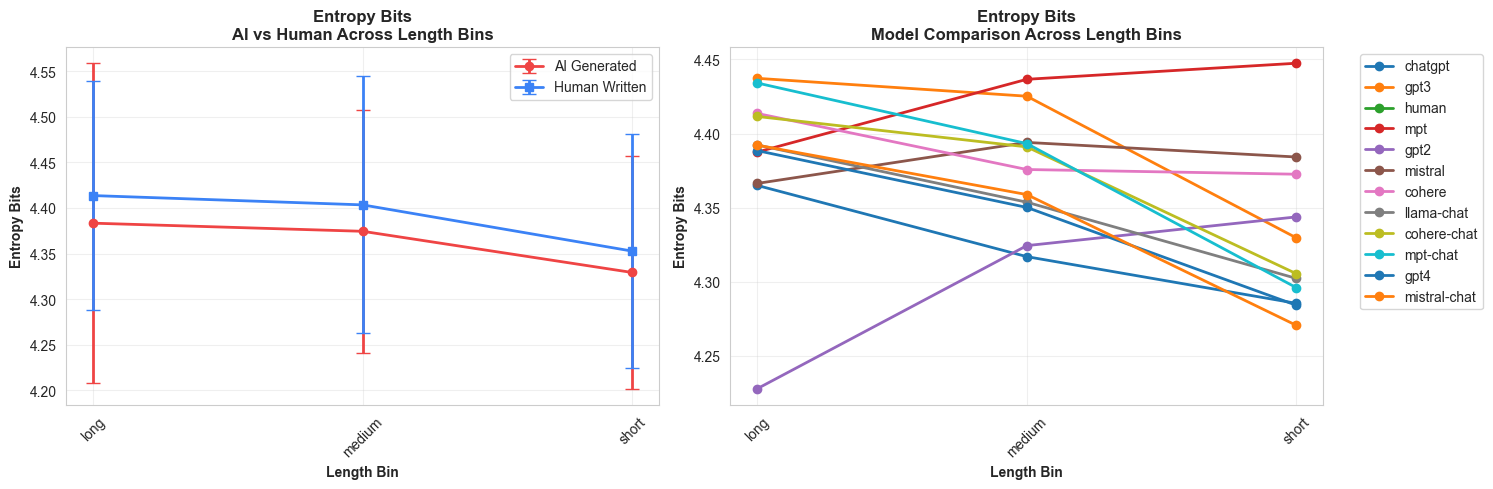


Statistical Analysis for: ENTROPY_BITS

AI Generated:
                mean       std
length_bin                    
long        4.383316  0.175653
medium      4.374393  0.133655
short       4.329153  0.127571

Human Written:
                mean       std
length_bin                    
long        4.413623  0.125816
medium      4.403408  0.141164
short       4.352638  0.128797


In [9]:
def analyze_feature_by_length(df, feature, show_models=False):
    """
    Analyze how a feature varies across length bins for AI vs Human
    and optionally show model-specific patterns
    """
    fig, axes = plt.subplots(1, 2 if show_models else 1, 
                            figsize=(15 if show_models else 10, 5))
    if not show_models:
        axes = [axes]
    
    # AI vs Human comparison
    ai_data = df[df['is_ai'] == True].groupby('length_bin')[feature].agg(['mean', 'std'])
    human_data = df[df['is_ai'] == False].groupby('length_bin')[feature].agg(['mean', 'std'])
    
    x = range(len(ai_data))
    width = 0.35
    
    axes[0].errorbar(x, ai_data['mean'], yerr=ai_data['std'], 
                     label='AI Generated', marker='o', linewidth=2, capsize=5, color='#ef4444')
    axes[0].errorbar(x, human_data['mean'], yerr=human_data['std'], 
                     label='Human Written', marker='s', linewidth=2, capsize=5, color='#3b82f6')
    axes[0].set_xlabel('Length Bin', fontweight='bold')
    axes[0].set_ylabel(feature.replace('_', ' ').title(), fontweight='bold')
    axes[0].set_title(f'{feature.replace("_", " ").title()}\nAI vs Human Across Length Bins', 
                     fontsize=12, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(ai_data.index, rotation=45)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Model-specific comparison (if requested)
    if show_models:
        for model in df['model'].unique():
            model_data = df[(df['model'] == model) & (df['is_ai'] == True)]
            model_means = model_data.groupby('length_bin')[feature].mean()
            axes[1].plot(range(len(model_means)), model_means, 
                        marker='o', linewidth=2, label=model)
        
        axes[1].set_xlabel('Length Bin', fontweight='bold')
        axes[1].set_ylabel(feature.replace('_', ' ').title(), fontweight='bold')
        axes[1].set_title(f'{feature.replace("_", " ").title()}\nModel Comparison Across Length Bins', 
                         fontsize=12, fontweight='bold')
        axes[1].set_xticks(range(len(model_means)))
        axes[1].set_xticklabels(model_means.index, rotation=45)
        axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n{'='*60}")
    print(f"Statistical Analysis for: {feature.upper()}")
    print(f"{'='*60}")
    print("\nAI Generated:")
    print(ai_data)
    print("\nHuman Written:")
    print(human_data)

# Example: Analyze entropy_bits
analyze_feature_by_length(df, 'entropy_bits', show_models=True)

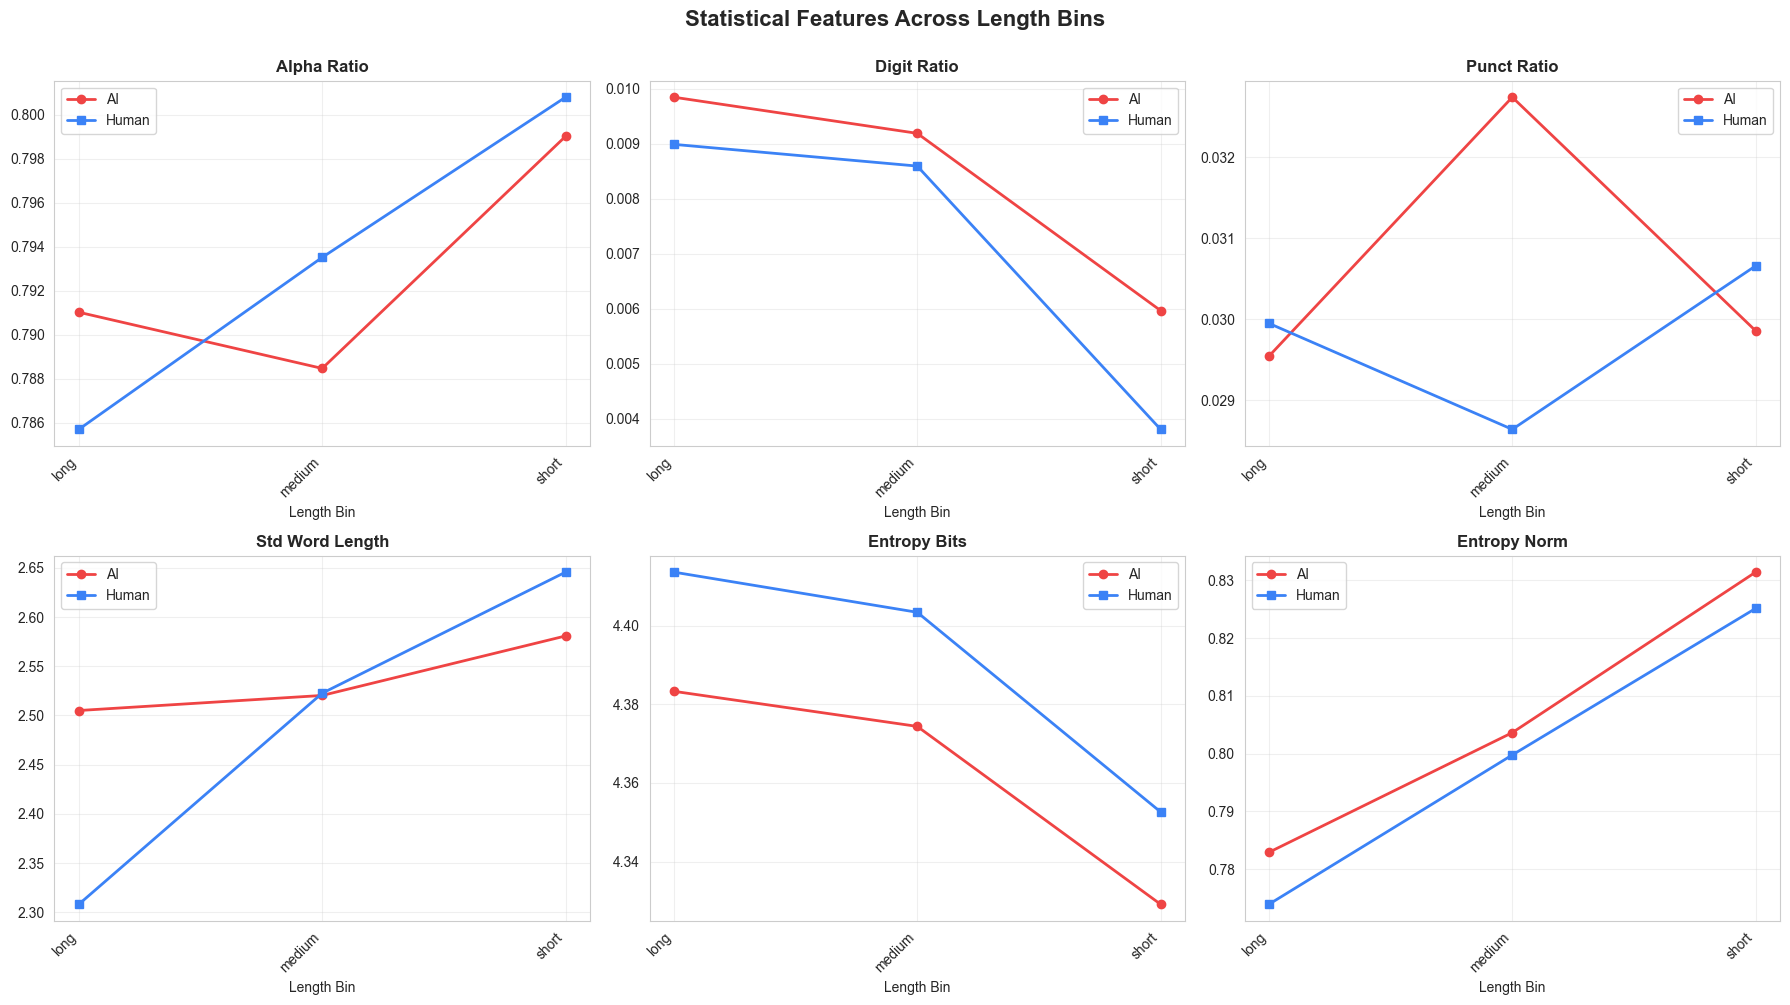

In [10]:
def analyze_multiple_features(df, features, category_name):
    """
    Create a grid of plots for multiple features
    """
    n_features = len(features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
    axes = axes.flatten() if n_features > 1 else [axes]
    
    for idx, feature in enumerate(features):
        if feature not in df.columns:
            axes[idx].text(0.5, 0.5, f'{feature}\nnot in dataset', 
                          ha='center', va='center')
            axes[idx].axis('off')
            continue
            
        ai_data = df[df['is_ai'] == True].groupby('length_bin')[feature].mean()
        human_data = df[df['is_ai'] == False].groupby('length_bin')[feature].mean()
        
        axes[idx].plot(range(len(ai_data)), ai_data.values, 
                      marker='o', linewidth=2, label='AI', color='#ef4444')
        axes[idx].plot(range(len(human_data)), human_data.values, 
                      marker='s', linewidth=2, label='Human', color='#3b82f6')
        axes[idx].set_title(feature.replace('_', ' ').title(), fontweight='bold')
        axes[idx].set_xlabel('Length Bin')
        axes[idx].set_xticks(range(len(ai_data)))
        axes[idx].set_xticklabels(ai_data.index, rotation=45, ha='right')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
    
    # Hide empty subplots
    for idx in range(n_features, len(axes)):
        axes[idx].axis('off')
    
    fig.suptitle(f'{category_name} Features Across Length Bins', 
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

# Analyze all statistical features
analyze_multiple_features(df, feature_categories['Statistical'], 'Statistical')

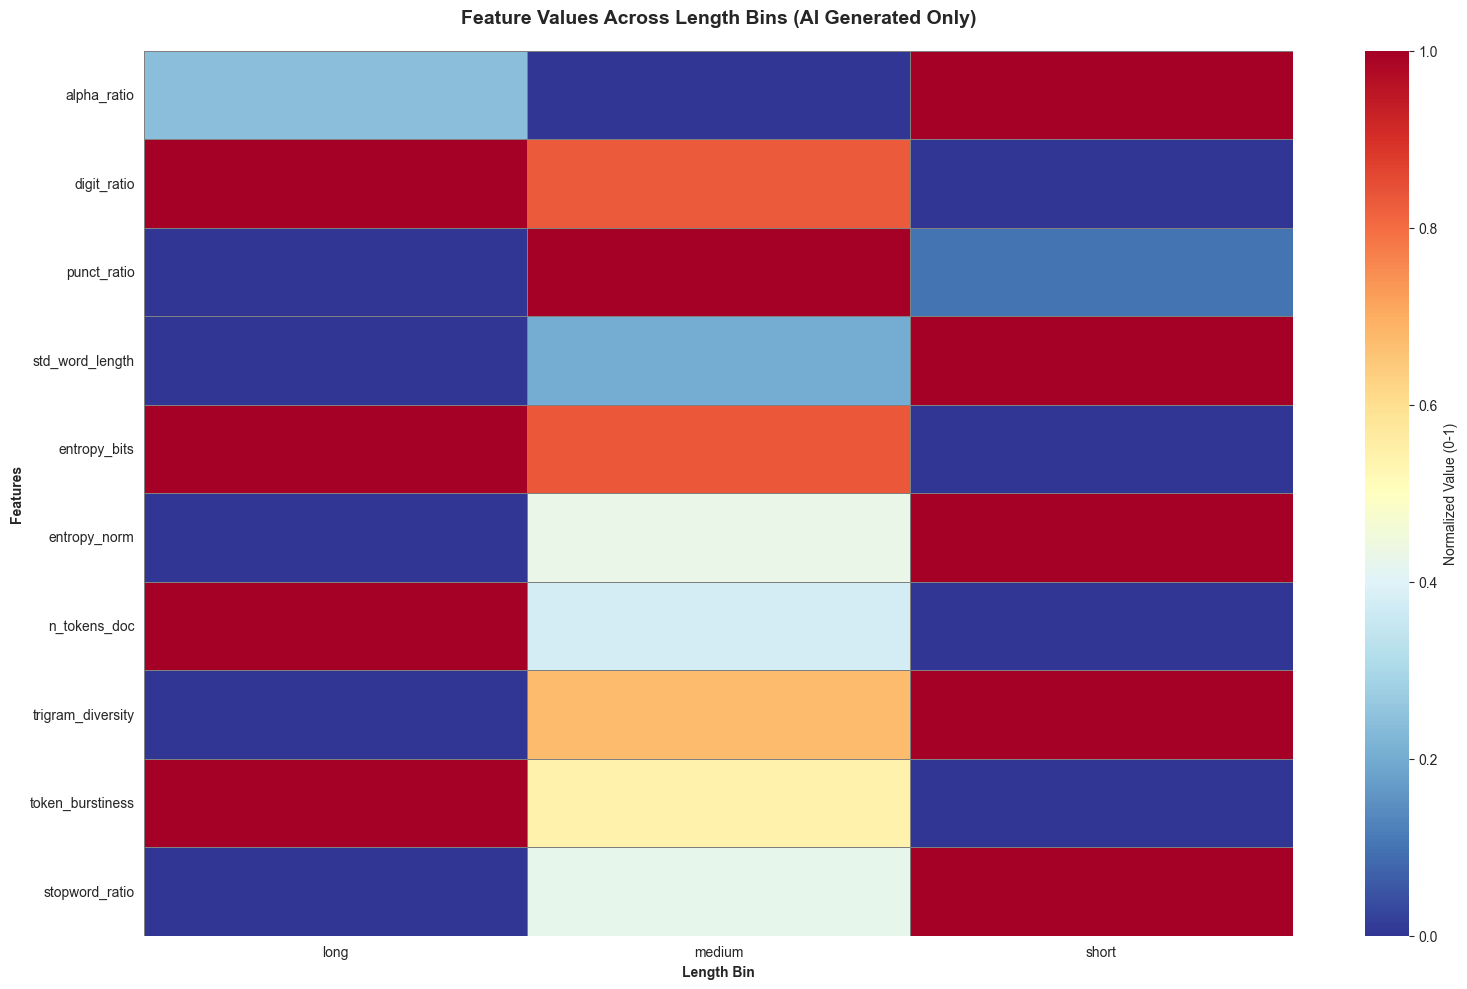

In [11]:
def create_feature_heatmap(df, features_subset=None, is_ai_only=True):
    """
    Create a heatmap showing how features vary across length bins
    """
    if features_subset is None:
        features_subset = all_features
    
    # Filter available features
    features_subset = [f for f in features_subset if f in df.columns]
    
    # Filter data
    plot_df = df[df['is_ai'] == True] if is_ai_only else df
    
    # Calculate means for each length bin
    heatmap_data = plot_df.groupby('length_bin')[features_subset].mean()
    
    # Normalize each feature to 0-1 scale for better visualization
    heatmap_normalized = (heatmap_data - heatmap_data.min()) / (heatmap_data.max() - heatmap_data.min())
    
    # Create heatmap
    plt.figure(figsize=(16, max(10, len(features_subset) * 0.3)))
    sns.heatmap(heatmap_normalized.T, cmap='RdYlBu_r', center=0.5, 
                cbar_kws={'label': 'Normalized Value (0-1)'}, 
                linewidths=0.5, linecolor='gray')
    plt.title(f'Feature Values Across Length Bins {"(AI Generated Only)" if is_ai_only else "(All Data)"}', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Length Bin', fontweight='bold')
    plt.ylabel('Features', fontweight='bold')
    plt.tight_layout()
    plt.show()

# Create heatmap for statistical and token-based features
selected_features = feature_categories['Statistical'] + feature_categories['Token-based']
create_feature_heatmap(df, selected_features, is_ai_only=True)

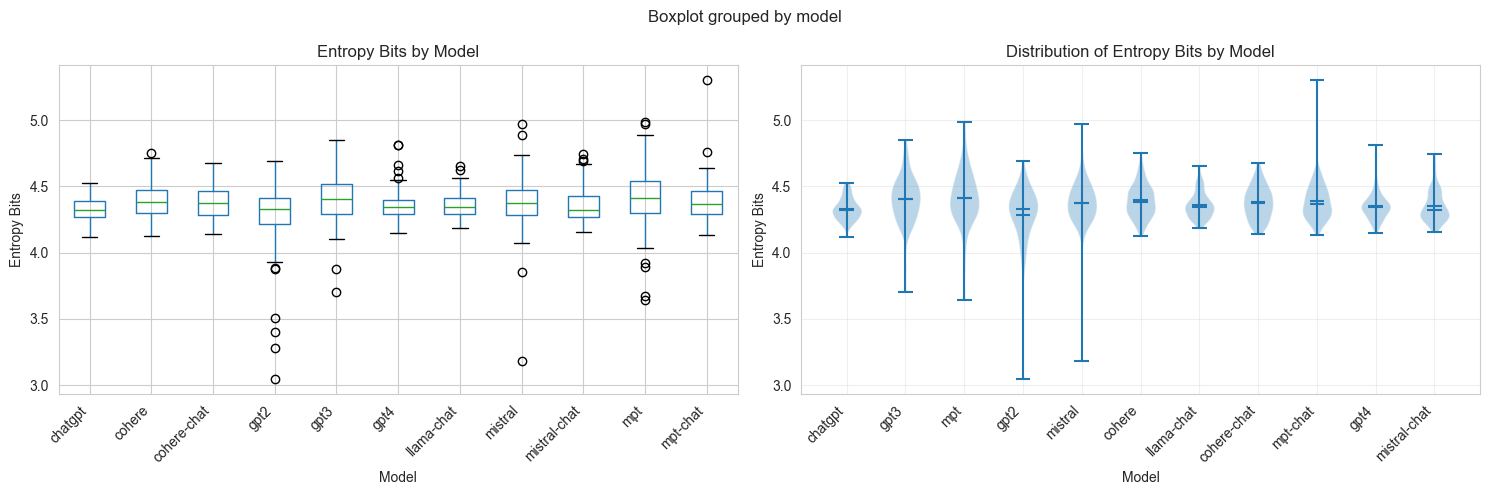


Statistical Summary by Model:
              count      mean       std       min       25%       50%  \
model                                                                   
chatgpt       139.0  4.332899  0.084278  4.115655  4.268852  4.324063   
cohere        137.0  4.394008  0.126943  4.127965  4.298471  4.380067   
cohere-chat   136.0  4.379893  0.125054  4.142870  4.285351  4.370954   
gpt2          136.0  4.281041  0.235143  3.045677  4.217156  4.327374   
gpt3          136.0  4.407346  0.171844  3.702266  4.293050  4.408483   
gpt4          136.0  4.352842  0.107195  4.147624  4.289322  4.345349   
llama-chat    136.0  4.360161  0.096600  4.188881  4.290136  4.342768   
mistral       136.0  4.377751  0.181737  3.182550  4.282998  4.373164   
mistral-chat  136.0  4.353460  0.119468  4.154308  4.268797  4.322551   
mpt           136.0  4.414780  0.210544  3.644523  4.299415  4.412887   
mpt-chat      136.0  4.389378  0.142885  4.133041  4.292327  4.364514   

                   

In [12]:
def compare_models_detailed(df, feature, length_bin=None):
    """
    Detailed comparison of models for a specific feature
    Optionally filter by length bin
    """
    data = df[df['is_ai'] == True].copy()
    if length_bin is not None:
        data = data[data['length_bin'] == length_bin]
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Box plot comparison
    data.boxplot(column=feature, by='model', ax=axes[0])
    axes[0].set_title(f'{feature.replace("_", " ").title()} by Model' + 
                     (f' (Length Bin: {length_bin})' if length_bin else ''))
    axes[0].set_xlabel('Model')
    axes[0].set_ylabel(feature.replace('_', ' ').title())
    plt.sca(axes[0])
    plt.xticks(rotation=45, ha='right')
    
    # Violin plot for distribution
    models = data['model'].unique()
    positions = range(len(models))
    violin_data = [data[data['model'] == m][feature].dropna() for m in models]
    
    parts = axes[1].violinplot(violin_data, positions=positions, showmeans=True, showmedians=True)
    axes[1].set_xticks(positions)
    axes[1].set_xticklabels(models, rotation=45, ha='right')
    axes[1].set_title(f'Distribution of {feature.replace("_", " ").title()} by Model')
    axes[1].set_xlabel('Model')
    axes[1].set_ylabel(feature.replace('_', ' ').title())
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical summary
    print(f"\nStatistical Summary by Model:")
    print("="*70)
    summary = data.groupby('model')[feature].describe()
    print(summary)

# Example: Compare models on entropy_bits
compare_models_detailed(df, 'entropy_bits')

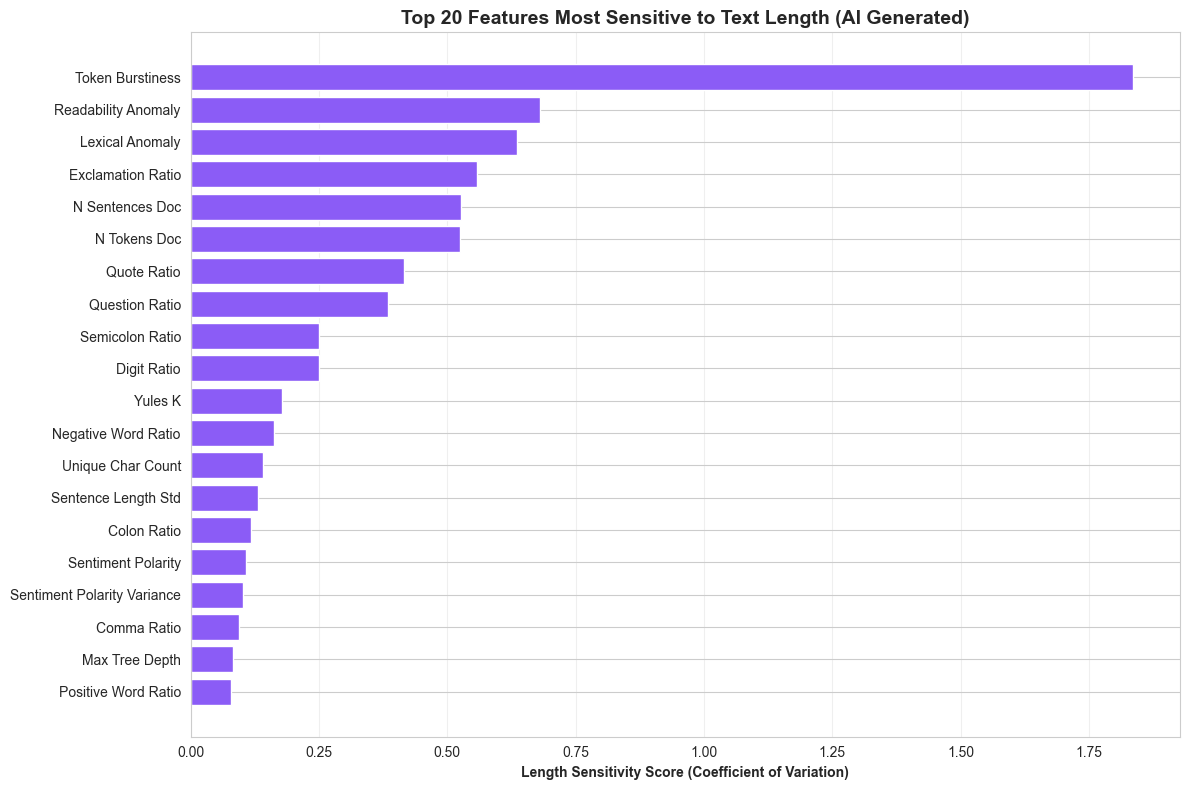


Top 10 most length-sensitive features:
1. token_burstiness: 1.8356
2. readability_anomaly: 0.6804
3. lexical_anomaly: 0.6367
4. exclamation_ratio: 0.5582
5. n_sentences_doc: 0.5269
6. n_tokens_doc: 0.5247
7. quote_ratio: 0.4154
8. question_ratio: 0.3849
9. semicolon_ratio: 0.2508
10. digit_ratio: 0.2493


In [13]:
def rank_features_by_length_sensitivity(df):
    """
    Rank features by how much they change across length bins for AI text
    """
    ai_df = df[df['is_ai'] == True]
    
    sensitivity_scores = {}
    
    for feature in all_features:
        if feature not in df.columns:
            continue
        
        # Calculate coefficient of variation across length bins
        means = ai_df.groupby('length_bin')[feature].mean()
        
        # Skip if all NaN
        if means.isna().all():
            continue
            
        # Calculate range normalized by mean (avoiding division by zero)
        mean_val = means.mean()
        if mean_val != 0:
            cv = means.std() / abs(mean_val)
        else:
            cv = 0
            
        sensitivity_scores[feature] = cv
    
    # Sort by sensitivity
    sorted_features = sorted(sensitivity_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Plot top 20
    top_n = 20
    top_features = sorted_features[:top_n]
    
    plt.figure(figsize=(12, 8))
    features_names = [f[0] for f in top_features]
    scores = [f[1] for f in top_features]
    
    plt.barh(range(len(features_names)), scores, color='#8b5cf6')
    plt.yticks(range(len(features_names)), [f.replace('_', ' ').title() for f in features_names])
    plt.xlabel('Length Sensitivity Score (Coefficient of Variation)', fontweight='bold')
    plt.title('Top 20 Features Most Sensitive to Text Length (AI Generated)', 
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    return sorted_features

# Run the analysis
sensitivity_ranking = rank_features_by_length_sensitivity(df)
print("\nTop 10 most length-sensitive features:")
for i, (feat, score) in enumerate(sensitivity_ranking[:10], 1):
    print(f"{i}. {feat}: {score:.4f}")

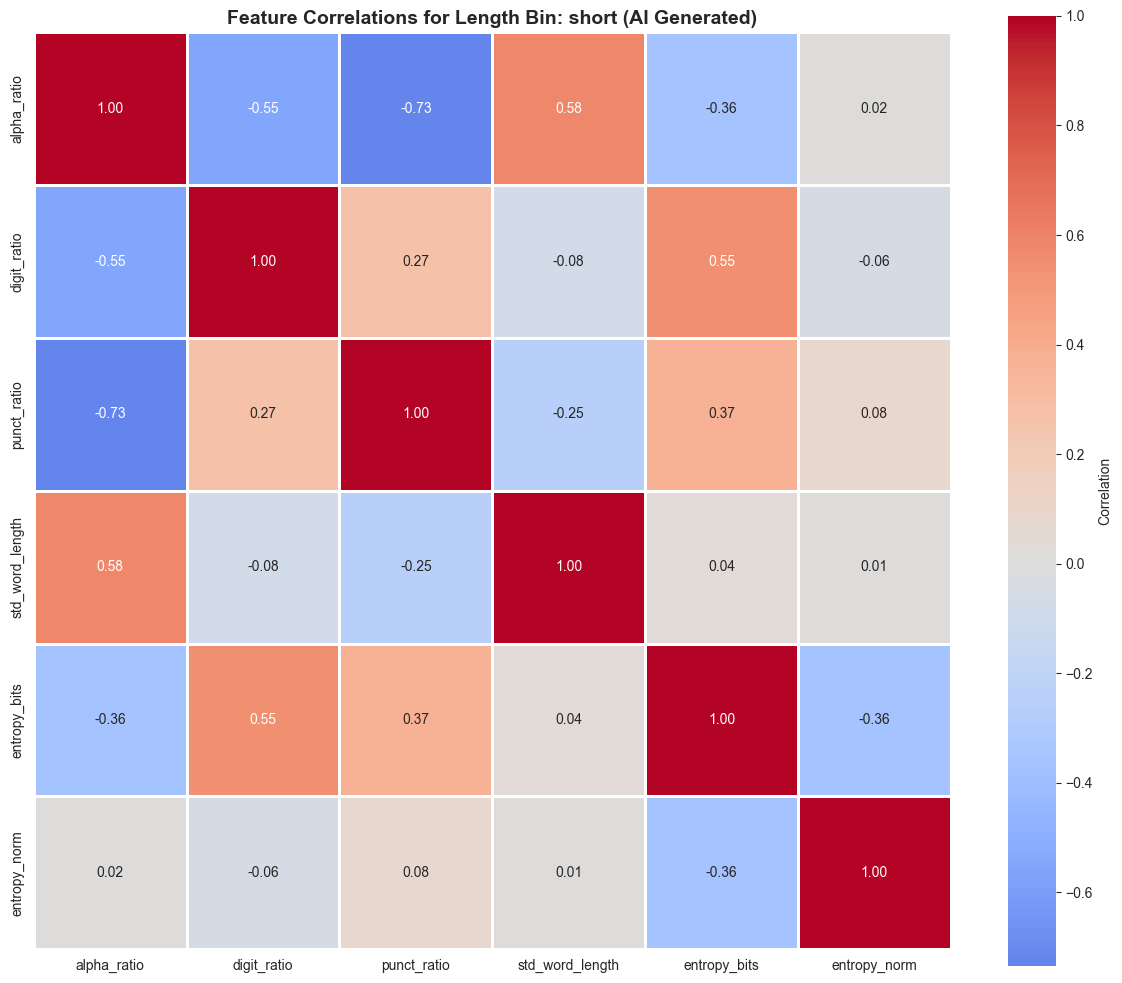

In [14]:
def analyze_feature_correlations_by_length(df, features_subset, length_bin):
    """
    Show correlation matrix for features within a specific length bin
    """
    data = df[(df['length_bin'] == length_bin) & (df['is_ai'] == True)]
    
    # Filter available features
    features_subset = [f for f in features_subset if f in df.columns]
    
    # Calculate correlation
    corr_matrix = data[features_subset].corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1, 
                cbar_kws={'label': 'Correlation'})
    plt.title(f'Feature Correlations for Length Bin: {length_bin} (AI Generated)', 
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Example: Analyze correlations for a specific length bin
# Change the length_bin value to analyze different bins
selected_bin = df['length_bin'].unique()[0]  # First available bin
analyze_feature_correlations_by_length(df, feature_categories['Statistical'], selected_bin)


ANALYZING CATEGORY: Statistical



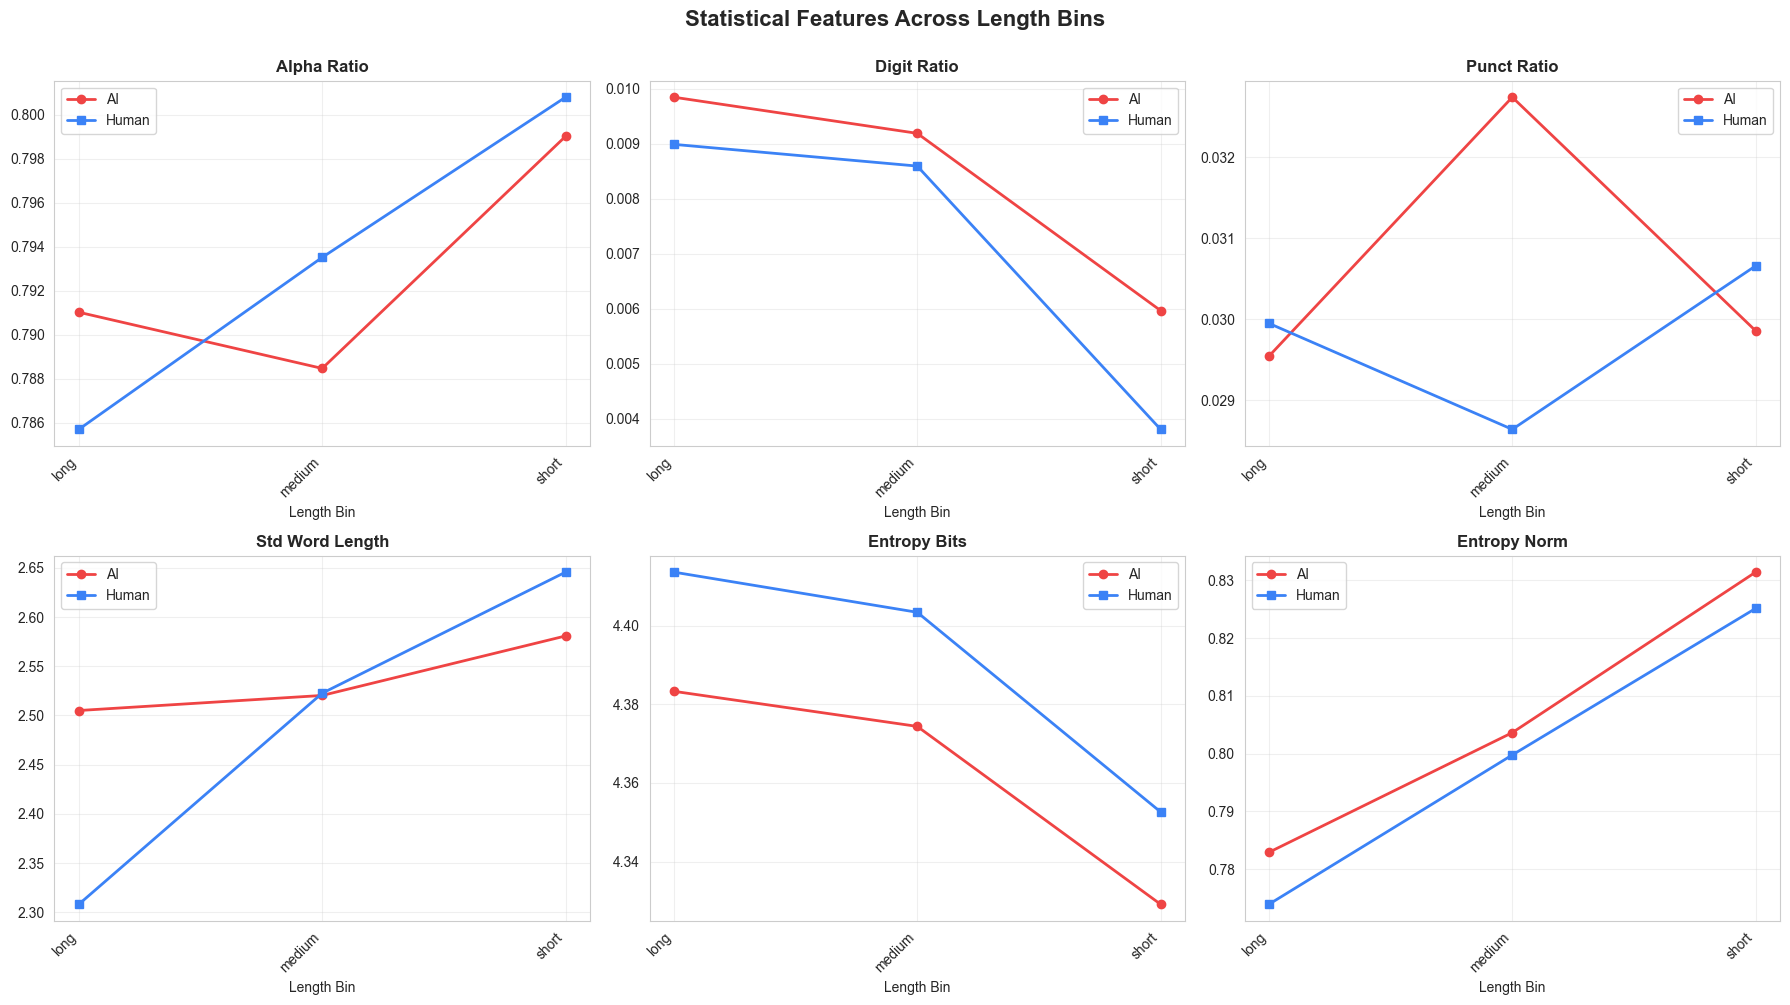

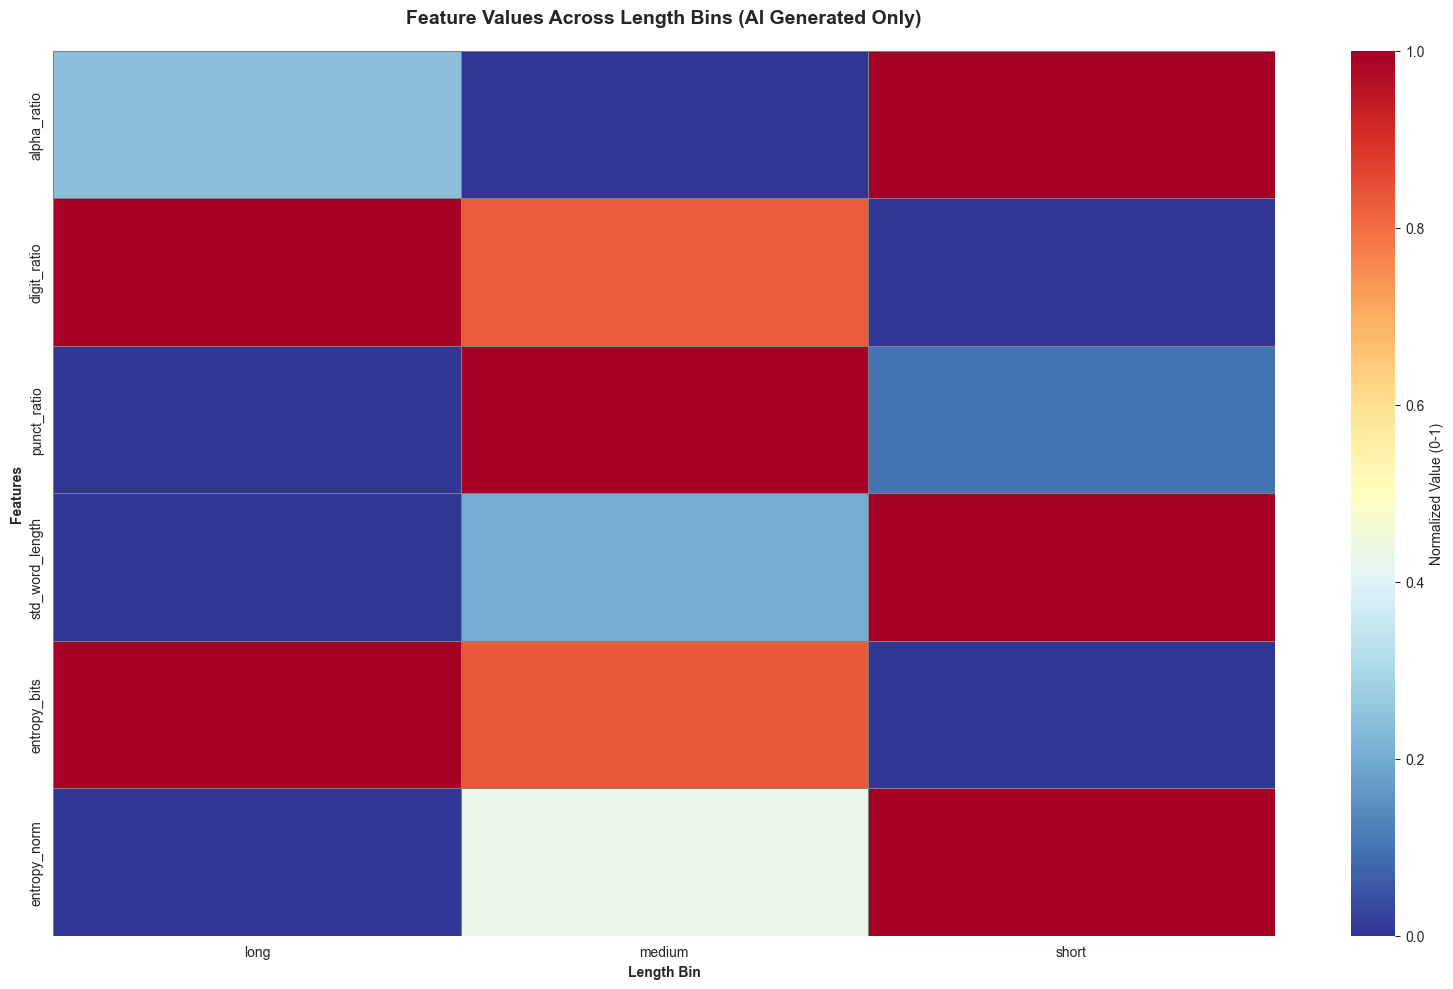


Detailed analysis of key features in Statistical:


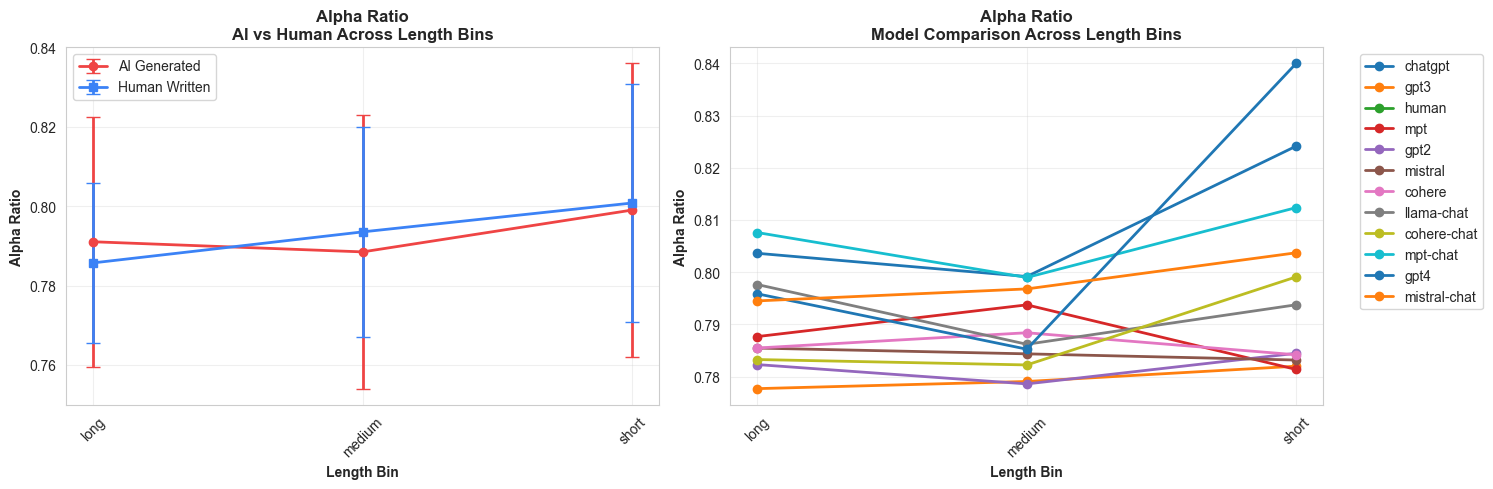


Statistical Analysis for: ALPHA_RATIO

AI Generated:
                mean       std
length_bin                    
long        0.791022  0.031511
medium      0.788470  0.034444
short       0.799009  0.036977

Human Written:
                mean       std
length_bin                    
long        0.785702  0.020100
medium      0.793511  0.026539
short       0.800786  0.029972


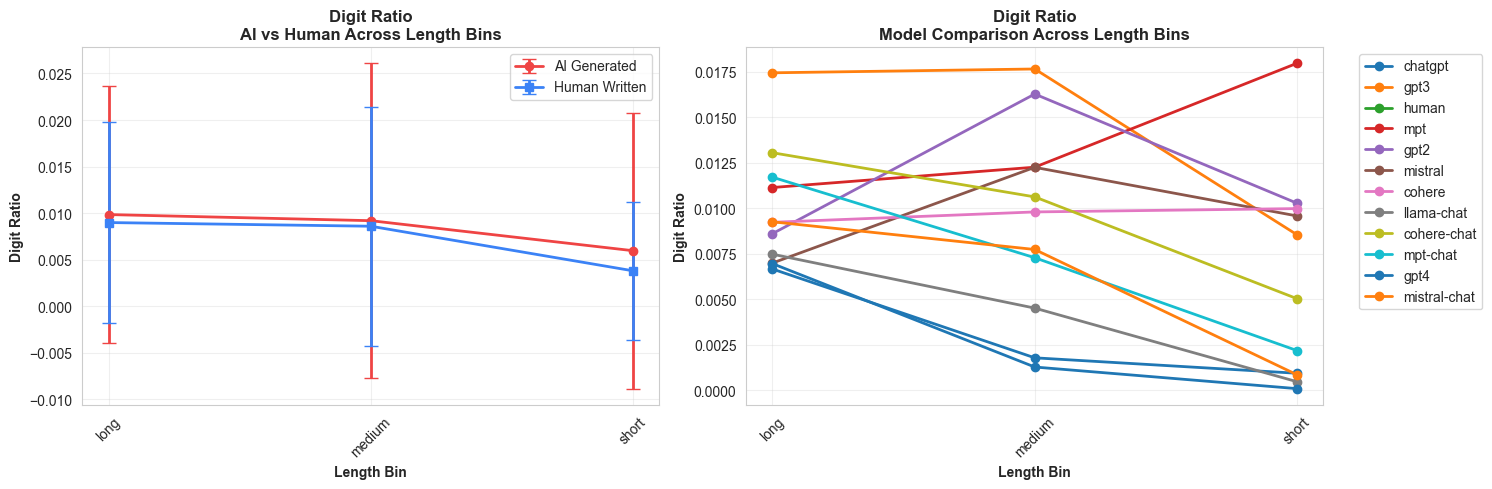


Statistical Analysis for: DIGIT_RATIO

AI Generated:
                mean       std
length_bin                    
long        0.009848  0.013792
medium      0.009190  0.016910
short       0.005966  0.014815

Human Written:
                mean       std
length_bin                    
long        0.008990  0.010834
medium      0.008595  0.012857
short       0.003805  0.007442


In [15]:
def full_category_analysis(df, category_name):
    """
    Complete analysis for a feature category
    """
    print(f"\n{'='*70}")
    print(f"ANALYZING CATEGORY: {category_name}")
    print(f"{'='*70}\n")
    
    features = feature_categories[category_name]
    
    # 1. Multiple features plot
    analyze_multiple_features(df, features, category_name)
    
    # 2. Heatmap
    create_feature_heatmap(df, features, is_ai_only=True)
    
    # 3. Individual detailed analysis for most important features
    print(f"\nDetailed analysis of key features in {category_name}:")
    for feature in features[:2]:  # Analyze top 2 features
        if feature in df.columns:
            analyze_feature_by_length(df, feature, show_models=True)

# Run for each category you want to analyze
# Example: Analyze Statistical features
full_category_analysis(df, 'Statistical')

DISCRIMINATION OVER LENGHT_BINS

In [ ]:
from sklearn.metrics import roc_auc_score
from scipy.stats import ttest_ind, mannwhitneyu
import numpy as np

def calculate_effect_size(group1, group2):
    """
    Calculate Cohen's d effect size
    Small effect: d = 0.2
    Medium effect: d = 0.5  
    Large effect: d = 0.8
    """
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    
    # Pooled standard deviation
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    
    if pooled_std == 0:
        return 0
    
    return (np.mean(group1) - np.mean(group2)) / pooled_std

def analyze_discriminative_power(df, length_bin, features_to_test=None):
    """
    Analyze which features best discriminate AI vs Human for a specific length bin
    """
    if features_to_test is None:
        features_to_test = all_features
    
    # Filter data for this length bin
    bin_data = df[df['length_bin'] == length_bin].copy()
    ai_data = bin_data[bin_data['is_ai'] == True]
    human_data = bin_data[bin_data['is_ai'] == False]
    
    results = []
    
    for feature in features_to_test:
        if feature not in df.columns:
            continue
        
        ai_values = ai_data[feature].dropna()
        human_values = human_data[feature].dropna()
        
        # Skip if not enough data
        if len(ai_values) < 10 or len(human_values) < 10:
            continue
        
        # 1. Calculate means
        ai_mean = ai_values.mean()
        human_mean = human_values.mean()
        difference = ai_mean - human_mean
        
        # 2. T-test (parametric)
        t_stat, p_value_ttest = ttest_ind(ai_values, human_values)
        
        # 3. Mann-Whitney U test (non-parametric, more robust)
        u_stat, p_value_mw = mannwhitneyu(ai_values, human_values, alternative='two-sided')
        
        # 4. Effect size (Cohen's d) - calculated manually
        effect_size = calculate_effect_size(ai_values, human_values)
        
        # 5. ROC AUC (how well this feature alone can classify)
        try:
            # Combine the data
            combined_values = np.concatenate([ai_values, human_values])
            combined_labels = np.concatenate([np.ones(len(ai_values)), np.zeros(len(human_values))])
            auc = roc_auc_score(combined_labels, combined_values)
            # Adjust AUC to be > 0.5 (direction doesn't matter for discrimination)
            auc = max(auc, 1 - auc)
        except:
            auc = 0.5
        
        # 6. Separation score (normalized difference)
        # How many standard deviations apart are the means?
        pooled_std = np.sqrt((ai_values.std()**2 + human_values.std()**2) / 2)
        if pooled_std > 0:
            separation = abs(difference) / pooled_std
        else:
            separation = 0
        
        results.append({
            'feature': feature,
            'ai_mean': ai_mean,
            'human_mean': human_mean,
            'difference': difference,
            'abs_difference': abs(difference),
            'p_value_ttest': p_value_ttest,
            'p_value_mannwhitney': p_value_mw,
            'effect_size': effect_size,
            'abs_effect_size': abs(effect_size),
            'auc': auc,
            'separation_score': separation,
            'ai_std': ai_values.std(),
            'human_std': human_values.std(),
            'ai_n': len(ai_values),
            'human_n': len(human_values)
        })
    
    results_df = pd.DataFrame(results)
    
    # Add significance flag
    results_df['is_significant'] = (results_df['p_value_mannwhitney'] < 0.05)
    
    # Create discriminative score (composite metric)
    # Combines AUC, effect size, and statistical significance
    results_df['discriminative_score'] = (
        results_df['auc'] * 0.4 +  # How well it classifies
        (results_df['abs_effect_size'] / 3).clip(0, 1) * 0.3 +  # Effect size (normalized)
        results_df['is_significant'].astype(float) * 0.3  # Statistical significance
    )
    
    return results_df.sort_values('discriminative_score', ascending=False)

# Example: Analyze length bin
length_bin_to_analyze = df['length_bin'].unique()[0]
results = analyze_discriminative_power(df, length_bin_to_analyze)

print(f"\nDISCRIMINATIVE POWER ANALYSIS FOR LENGTH BIN: {length_bin_to_analyze}")
print("="*100)
print("\nTop 15 Most Discriminative Features:")
print(results[['feature', 'auc', 'effect_size', 'p_value_mannwhitney', 
               'discriminative_score', 'is_significant']].head(15))

ImportError: cannot import name 'cohen_d' from 'scipy.stats' (c:\Users\marco\OneDrive\Desktop\Tesi_Codice\Cognitive_TaskGen\.venv\Lib\site-packages\scipy\stats\__init__.py)

In [17]:
def visualize_discriminative_features(df, length_bin, top_n=10):
    """
    Visualize the most discriminative features for a length bin
    """
    results = analyze_discriminative_power(df, length_bin)
    top_features = results.head(top_n)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. AUC Score
    axes[0, 0].barh(range(len(top_features)), top_features['auc'], 
                     color=['#10b981' if sig else '#94a3b8' 
                           for sig in top_features['is_significant']])
    axes[0, 0].set_yticks(range(len(top_features)))
    axes[0, 0].set_yticklabels([f.replace('_', ' ').title() for f in top_features['feature']])
    axes[0, 0].axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Random (0.5)')
    axes[0, 0].set_xlabel('AUC Score', fontweight='bold')
    axes[0, 0].set_title('Classification Power (AUC)', fontweight='bold')
    axes[0, 0].set_xlim([0.5, 1.0])
    axes[0, 0].invert_yaxis()
    axes[0, 0].grid(True, alpha=0.3, axis='x')
    
    # 2. Effect Size (Cohen's d)
    colors = ['#ef4444' if abs(es) > 0.8 else '#f59e0b' if abs(es) > 0.5 else '#3b82f6' 
              for es in top_features['effect_size']]
    axes[0, 1].barh(range(len(top_features)), top_features['effect_size'], color=colors)
    axes[0, 1].set_yticks(range(len(top_features)))
    axes[0, 1].set_yticklabels([f.replace('_', ' ').title() for f in top_features['feature']])
    axes[0, 1].axvline(x=0, color='black', linestyle='-', alpha=0.3)
    axes[0, 1].axvline(x=0.2, color='gray', linestyle='--', alpha=0.3, label='Small')
    axes[0, 1].axvline(x=0.5, color='gray', linestyle='--', alpha=0.3, label='Medium')
    axes[0, 1].axvline(x=0.8, color='gray', linestyle='--', alpha=0.3, label='Large')
    axes[0, 1].axvline(x=-0.2, color='gray', linestyle='--', alpha=0.3)
    axes[0, 1].axvline(x=-0.5, color='gray', linestyle='--', alpha=0.3)
    axes[0, 1].axvline(x=-0.8, color='gray', linestyle='--', alpha=0.3)
    axes[0, 1].set_xlabel('Effect Size (Cohen\'s d)', fontweight='bold')
    axes[0, 1].set_title('Effect Size\n(Negative = Human higher, Positive = AI higher)', 
                         fontweight='bold')
    axes[0, 1].invert_yaxis()
    axes[0, 1].grid(True, alpha=0.3, axis='x')
    
    # 3. P-values (log scale)
    p_values = -np.log10(top_features['p_value_mannwhitney'].clip(lower=1e-50))
    axes[1, 0].barh(range(len(top_features)), p_values,
                     color=['#10b981' if sig else '#94a3b8' 
                           for sig in top_features['is_significant']])
    axes[1, 0].set_yticks(range(len(top_features)))
    axes[1, 0].set_yticklabels([f.replace('_', ' ').title() for f in top_features['feature']])
    axes[1, 0].axvline(x=-np.log10(0.05), color='red', linestyle='--', 
                       alpha=0.5, label='p=0.05')
    axes[1, 0].set_xlabel('-log10(p-value)', fontweight='bold')
    axes[1, 0].set_title('Statistical Significance\n(Higher = More Significant)', 
                         fontweight='bold')
    axes[1, 0].invert_yaxis()
    axes[1, 0].grid(True, alpha=0.3, axis='x')
    
    # 4. Composite Discriminative Score
    axes[1, 1].barh(range(len(top_features)), top_features['discriminative_score'],
                     color='#8b5cf6')
    axes[1, 1].set_yticks(range(len(top_features)))
    axes[1, 1].set_yticklabels([f.replace('_', ' ').title() for f in top_features['feature']])
    axes[1, 1].set_xlabel('Discriminative Score', fontweight='bold')
    axes[1, 1].set_title('Overall Discriminative Power\n(Composite Score)', 
                         fontweight='bold')
    axes[1, 1].invert_yaxis()
    axes[1, 1].grid(True, alpha=0.3, axis='x')
    
    fig.suptitle(f'Most Discriminative Features for Length Bin: {length_bin}', 
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

# Visualize for a specific length bin
visualize_discriminative_features(df, length_bin_to_analyze, top_n=15)

NameError: name 'length_bin_to_analyze' is not defined

In [ ]:
def compare_discriminative_across_bins(df, feature):
    """
    Show how discriminative power of a feature changes across length bins
    """
    length_bins = sorted(df['length_bin'].unique())
    
    metrics = {
        'length_bin': [],
        'auc': [],
        'effect_size': [],
        'p_value': [],
        'separation': []
    }
    
    for length_bin in length_bins:
        result = analyze_discriminative_power(df, length_bin, [feature])
        if len(result) > 0:
            metrics['length_bin'].append(length_bin)
            metrics['auc'].append(result.iloc[0]['auc'])
            metrics['effect_size'].append(result.iloc[0]['abs_effect_size'])
            metrics['p_value'].append(-np.log10(result.iloc[0]['p_value_mannwhitney'].clip(lower=1e-50)))
            metrics['separation'].append(result.iloc[0]['separation_score'])
    
    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    x = range(len(metrics['length_bin']))
    
    # AUC across bins
    axes[0, 0].plot(x, metrics['auc'], marker='o', linewidth=2, color='#10b981')
    axes[0, 0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random')
    axes[0, 0].set_title('AUC Score Across Length Bins', fontweight='bold')
    axes[0, 0].set_ylabel('AUC')
    axes[0, 0].set_ylim([0.5, 1.0])
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()
    
    # Effect Size across bins
    axes[0, 1].plot(x, metrics['effect_size'], marker='s', linewidth=2, color='#f59e0b')
    axes[0, 1].axhline(y=0.2, color='gray', linestyle='--', alpha=0.3, label='Small')
    axes[0, 1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.3, label='Medium')
    axes[0, 1].axhline(y=0.8, color='gray', linestyle='--', alpha=0.3, label='Large')
    axes[0, 1].set_title('Effect Size Across Length Bins', fontweight='bold')
    axes[0, 1].set_ylabel('|Cohen\'s d|')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()
    
    # P-value across bins
    axes[1, 0].plot(x, metrics['p_value'], marker='^', linewidth=2, color='#ef4444')
    axes[1, 0].axhline(y=-np.log10(0.05), color='red', linestyle='--', alpha=0.5, label='p=0.05')
    axes[1, 0].set_title('Statistical Significance Across Length Bins', fontweight='bold')
    axes[1, 0].set_ylabel('-log10(p-value)')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()
    
    # Separation score across bins
    axes[1, 1].plot(x, metrics['separation'], marker='D', linewidth=2, color='#8b5cf6')
    axes[1, 1].set_title('Separation Score Across Length Bins', fontweight='bold')
    axes[1, 1].set_ylabel('Separation (std deviations)')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Set x-axis for all plots
    for ax in axes.flat:
        ax.set_xlabel('Length Bin', fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(metrics['length_bin'], rotation=45, ha='right')
    
    fig.suptitle(f'Discriminative Power of "{feature}" Across Length Bins', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Example: See how entropy_bits performs across all bins
compare_discriminative_across_bins(df, 'entropy_bits')

In [ ]:
def create_discriminative_heatmap(df, features_subset=None, metric='auc'):
    """
    Create heatmap showing discriminative power of features across all length bins
    metric options: 'auc', 'effect_size', 'discriminative_score'
    """
    if features_subset is None:
        features_subset = all_features
    
    length_bins = sorted(df['length_bin'].unique())
    
    # Calculate discriminative power for each bin
    heatmap_data = []
    
    for length_bin in length_bins:
        results = analyze_discriminative_power(df, length_bin, features_subset)
        bin_scores = {}
        for _, row in results.iterrows():
            if metric == 'effect_size':
                bin_scores[row['feature']] = row['abs_effect_size']
            elif metric == 'discriminative_score':
                bin_scores[row['feature']] = row['discriminative_score']
            else:  # default to auc
                bin_scores[row['feature']] = row['auc']
        heatmap_data.append(bin_scores)
    
    # Convert to DataFrame
    heatmap_df = pd.DataFrame(heatmap_data, index=length_bins)
    
    # Sort columns by average discriminative power
    col_means = heatmap_df.mean().sort_values(ascending=False)
    heatmap_df = heatmap_df[col_means.index]
    
    # Plot
    plt.figure(figsize=(16, max(8, len(length_bins) * 0.5)))
    
    if metric == 'auc':
        sns.heatmap(heatmap_df, cmap='RdYlGn', center=0.5, vmin=0.5, vmax=1.0,
                   annot=True, fmt='.3f', linewidths=0.5, 
                   cbar_kws={'label': 'AUC Score'})
    elif metric == 'effect_size':
        sns.heatmap(heatmap_df, cmap='RdYlGn', center=0.5, vmin=0, vmax=2,
                   annot=True, fmt='.3f', linewidths=0.5,
                   cbar_kws={'label': '|Cohen\'s d|'})
    else:
        sns.heatmap(heatmap_df, cmap='RdYlGn', center=0.5, vmin=0, vmax=1.0,
                   annot=True, fmt='.3f', linewidths=0.5,
                   cbar_kws={'label': 'Discriminative Score'})
    
    plt.title(f'Discriminative Power ({metric.upper()}) Across Length Bins', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Features (sorted by average discriminative power)', fontweight='bold')
    plt.ylabel('Length Bin', fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return heatmap_df

# Create heatmap for top features
top_features_list = feature_categories['Statistical'] + feature_categories['Token-based']
discriminative_heatmap = create_discriminative_heatmap(df, top_features_list, metric='auc')

In [ ]:
def find_best_features_per_bin(df, top_n=5):
    """
    For each length bin, identify the top N most discriminative features
    """
    length_bins = sorted(df['length_bin'].unique())
    
    summary = []
    
    for length_bin in length_bins:
        results = analyze_discriminative_power(df, length_bin)
        top_features = results.head(top_n)
        
        print(f"\n{'='*80}")
        print(f"LENGTH BIN: {length_bin}")
        print(f"{'='*80}")
        print(f"\nTop {top_n} Most Discriminative Features:")
        print(f"{'Rank':<6}{'Feature':<30}{'AUC':<10}{'Effect Size':<15}{'Significant':<12}")
        print("-" * 80)
        
        for idx, row in top_features.iterrows():
            sig = "Yes" if row['is_significant'] else "No"
            print(f"{idx+1:<6}{row['feature']:<30}{row['auc']:<10.3f}"
                  f"{row['effect_size']:<15.3f}{sig:<12}")
            
            summary.append({
                'length_bin': length_bin,
                'rank': idx + 1,
                'feature': row['feature'],
                'auc': row['auc'],
                'effect_size': row['effect_size'],
                'p_value': row['p_value_mannwhitney'],
                'discriminative_score': row['discriminative_score']
            })
    
    return pd.DataFrame(summary)

# Find best features for each bin
best_features_summary = find_best_features_per_bin(df, top_n=5)

In [ ]:
def plot_distributions_for_discriminative_feature(df, feature, length_bin):
    """
    Show detailed distribution comparison for AI vs Human on a discriminative feature
    """
    bin_data = df[df['length_bin'] == length_bin]
    ai_values = bin_data[bin_data['is_ai'] == True][feature].dropna()
    human_values = bin_data[bin_data['is_ai'] == False][feature].dropna()
    
    # Calculate statistics
    results = analyze_discriminative_power(df, length_bin, [feature])
    if len(results) == 0:
        print("No data available")
        return
    
    stats = results.iloc[0]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. Histogram comparison
    bins_hist = 30
    axes[0].hist(human_values, bins=bins_hist, alpha=0.6, label='Human', color='#3b82f6', density=True)
    axes[0].hist(ai_values, bins=bins_hist, alpha=0.6, label='AI', color='#ef4444', density=True)
    axes[0].set_xlabel(feature.replace('_', ' ').title(), fontweight='bold')
    axes[0].set_ylabel('Density', fontweight='bold')
    axes[0].set_title('Distribution Overlap', fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 2. Box plot comparison
    box_data = [human_values, ai_values]
    bp = axes[1].boxplot(box_data, labels=['Human', 'AI'], patch_artist=True)
    bp['boxes'][0].set_facecolor('#3b82f6')
    bp['boxes'][1].set_facecolor('#ef4444')
    axes[1].set_ylabel(feature.replace('_', ' ').title(), fontweight='bold')
    axes[1].set_title('Box Plot Comparison', fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # 3. Statistics summary
    axes[2].axis('off')
    stats_text = f"""
    DISCRIMINATIVE STATISTICS
    {'='*35}
    
    Length Bin: {length_bin}
    
    Sample Sizes:
      AI: {int(stats['ai_n'])}
      Human: {int(stats['human_n'])}
    
    Means:
      AI: {stats['ai_mean']:.4f}
      Human: {stats['human_mean']:.4f}
      Difference: {stats['difference']:.4f}
    
    Discriminative Metrics:
      AUC: {stats['auc']:.4f}
      Effect Size: {stats['effect_size']:.4f}
      p-value: {stats['p_value_mannwhitney']:.2e}
      Significant: {'Yes' if stats['is_significant'] else 'No'}
    
    Interpretation:
      AUC > 0.7: Good discrimination
      |Effect Size| > 0.5: Medium effect
      |Effect Size| > 0.8: Large effect
    """
    axes[2].text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
                verticalalignment='center')
    
    fig.suptitle(f'Distribution Analysis: {feature} (Length Bin: {length_bin})', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Example: Plot distribution for a discriminative feature
# First find the best feature for a bin
length_bin_example = df['length_bin'].unique()[0]
best_feature_results = analyze_discriminative_power(df, length_bin_example)
best_feature = best_feature_results.iloc[0]['feature']

plot_distributions_for_discriminative_feature(df, best_feature, length_bin_example)

In [ ]:
def export_discriminative_analysis(df, output_file='discriminative_analysis.csv'):
    """
    Export complete discriminative analysis to CSV for further examination
    """
    all_results = []
    
    for length_bin in sorted(df['length_bin'].unique()):
        results = analyze_discriminative_power(df, length_bin)
        results['length_bin'] = length_bin
        all_results.append(results)
    
    combined_results = pd.concat(all_results, ignore_index=True)
    combined_results = combined_results.sort_values(['length_bin', 'discriminative_score'], 
                                                     ascending=[True, False])
    
    combined_results.to_csv(output_file, index=False)
    print(f"Complete discriminative analysis exported to {output_file}")
    print(f"Total rows: {len(combined_results)}")
    
    return combined_results

# Export all discriminative metrics
full_discriminative_df = export_discriminative_analysis(df)
full_discriminative_df.head(20)